# **Motion Primitives Builder** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1i72a6KgMPi3Uw8UZ1W04JsIq45_r4_lh?usp=sharing)

> Author: *Andrew Milko*

*   this `.ipynb` implements motion primitives generation using [Pyomo](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/06.03-Path-Planning-for-a-Simple-Car.html) library.
*   primitives are exported into `.json` format and used in the [Truck](https://github.com/robotics-laboratory/truck) project of the [Robotics Group](https://cs.hse.ru/robotics), HSE University

___
### Libraries

In [1]:
import json
import math
import types
import requests
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_ipopt()

from pyomo.environ import *
from pyomo.dae import *

pyomo was previously installed
ipopt was previously installed


___
### Config

In [2]:
# https://github.com/robotics-laboratory/truck/blob/master/packages/model/config/model.yaml

density = 15                                # number of poses in primitive

tf = 100                                    # primitive time travel (s)
L = 0.505                                   # truck length (m)
wheel_r = 0.0525                            # wheel radius (m)
phi_max = 0.7                               # max steering angle (radians)

v_min = 0.0                                 # min velocity (m/s)
v_max = 0.8                                 # max velocity (m/s)

av_max = 1.0                                # max acceleration
ar_max = (v_max ** 2) * math.sin(40) / L    # max lateral acceleration

yaws_count = 12

# yaw radians values should in the half-interval [-pi; pi)
min_yaw = -math.pi
max_yaw = math.pi

yaws = []
for i in range(yaws_count):
  yaw = min_yaw + math.radians(30) * i
  assert(yaw < max_yaw and yaw >= min_yaw)
  yaws.append(yaw)

print('ar_max: {0}'.format(ar_max))
print('yaws: {0}'.format(yaws))

ar_max: 0.9443018271421453
yaws: [-3.141592653589793, -2.6179938779914944, -2.0943951023931957, -1.5707963267948966, -1.0471975511965979, -0.5235987755982991, 0.0, 0.5235987755982987, 1.0471975511965974, 1.5707963267948966, 2.094395102393195, 2.617993877991494]


___
### Optimization Solver

In [3]:
def buildModel(start_pose, end_pose, density):
  start_x, start_y, start_yaw = start_pose[0], start_pose[1], start_pose[2]
  end_x, end_y, end_yaw = end_pose[0], end_pose[1], end_pose[2]

  # create a model object
  m = ConcreteModel()

  # define the independent variable
  m.t = ContinuousSet(bounds=(0, tf))

  # define control inputs
  m.av = Var(m.t)
  m.phi = Var(m.t, bounds=(-phi_max, phi_max))

  # define the dependent variables
  m.x = Var(m.t)
  m.y = Var(m.t)
  m.a = Var(m.t)
  m.v = Var(m.t)

  # define derivatives
  m.x_dot = DerivativeVar(m.x)
  m.y_dot = DerivativeVar(m.y)
  m.a_dot = DerivativeVar(m.a)
  m.v_dot = DerivativeVar(m.v)

  # define the differential equation as constraints

  @m.Constraint(m.t)
  def ode_x(m, t):
      return m.x_dot[t] == m.v[t]*cos(m.a[t])

  @m.Constraint(m.t)
  def ode_y(m, t):
      return m.y_dot[t] == m.v[t]*sin(m.a[t])

  @m.Constraint(m.t)
  def ode_a(m, t):
      return m.a_dot[t] == m.v[t]*tan(m.phi[t])/L

  @m.Constraint(m.t)
  def ode_v(m, t):
      return m.v_dot[t] == m.av[t]

  # path constraints
  m.path_v1 = Constraint(m.t, rule=lambda m, t: m.v[t] <= v_max)
  m.path_v2 = Constraint(m.t, rule=lambda m, t: m.v[t] >= v_min)
  m.path_a1 = Constraint(m.t, rule=lambda m, t: m.av[t] <= av_max)
  m.path_a2 = Constraint(m.t, rule=lambda m, t: m.av[t] >= -av_max)
  m.path_a3 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L <= ar_max)
  m.path_a4 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L >= -ar_max)

  # initial conditions
  m.pc = ConstraintList()
  m.pc.add(m.x[0]==start_x)
  m.pc.add(m.y[0]==start_y)
  m.pc.add(m.a[0]==start_yaw)
  m.pc.add(m.v[0]==0)

  # final conditions
  m.pc.add(m.x[tf]==end_x)
  m.pc.add(m.y[tf]==end_y)
  m.pc.add(m.a[tf]==end_yaw)
  m.pc.add(m.v[tf]==0)

  # final conditions on the control inputs
  m.pc.add(m.av[tf]==0)
  m.pc.add(m.phi[tf]==0)

  # define the optimization objective
  m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.av[t]**2 + (m.v[t]**2*sin(m.phi[t])/L)**2)
  m.obj = Objective(expr=m.integral)

  # transform and solve
  TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=density-1)
  SolverFactory('ipopt').solve(m)

  return m

In [4]:
def getPrimitiveByModel(model):
  x = np.array([model.x[t]() for t in model.t])
  y = np.array([model.y[t]() for t in model.t])
  a = np.array([model.a[t]() for t in model.t])

  # convert 'a' values in [-pi; pi) interval
  for i in range(len(a)):
    a[i] = math.remainder(a[i], 2 * math.pi)
    if (a[i] == math.pi):
      a[i] -= 1e-5
    assert(a[i] >= min_yaw and a[i] < max_yaw)

  primitive = dict()
  primitive['x'] = x
  primitive['y'] = y
  primitive['a'] = a

  primitive['length'] = 0.0

  for i in range(1, x.size):
    primitive['length'] += np.linalg.norm(np.array([x[i], y[i]]) - np.array([x[(i - 1)], y[(i - 1)]]))

  return primitive

___
### Visualization

In [5]:
def plot_primitive_by_model(model, ax):
  scl=1.0

  def plotCar(x=0, y=0, a=0, phi=0):
      R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
      car = np.array([[wheel_r, 0.5*L], [-wheel_r, 0.5*L], [0, 0.5*L], [0, -0.5*L],
                      [wheel_r, -0.5*L], [-wheel_r, -0.5*L], [0, -0.5*L], [0, 0], [L, 0], [L, 0.5*L],
                      [L + wheel_r*np.cos(phi), 0.5*L + wheel_r*np.sin(phi)],
                      [L - wheel_r*np.cos(phi), 0.5*L - wheel_r*np.sin(phi)], [L, 0.5*L],[L, -0.5*L],
                      [L + wheel_r*np.cos(phi), -0.5*L + wheel_r*np.sin(phi)],
                      [L - wheel_r*np.cos(phi), -0.5*L - wheel_r*np.sin(phi)]])
      carz = scl*R.dot(car.T)
      ax.plot(x + carz[0], y + carz[1], 'k', lw=1.5, alpha=0.5)

  x = np.array([model.x[t]() for t in model.t])
  y = np.array([model.y[t]() for t in model.t])
  a = np.array([model.a[t]() for t in model.t])
  phi = np.array([model.phi[t]() for t in model.t])

  plotCar(x[0], y[0], a[0], scl*phi[0])
  plotCar(x[-1], y[-1], a[-1], scl*phi[-1])

  ax.set_aspect('equal', adjustable='box')
  ax.scatter(x, y, alpha=0.4, color='b', s=40)
  ax.plot(x, y, 'gray', lw=1, alpha=0.5)
  return ax

def plotPrimitiveByModel(model):
  fig, ax = plt.subplots(figsize=(5,5))
  plot_primitive_by_model(model, ax)
  plt.grid()

In [6]:
def plotLogsByModel(model):
    # access the results
    t = np.array([t for t in model.t])
    a = np.array([model.a[t]() for t in model.t])
    v = np.array([model.v[t]() for t in model.t])
    av = np.array([model.av[t]() for t in model.t])
    phi = np.array([model.phi[t]() for t in model.t])

    fig, ax = plt.subplots(3, 1, figsize=(4.5, 4), layout="constrained")

    ax[0].plot(t, av, color='orange')
    ax[0].plot(t, v**2*np.sin(phi)/L, color='brown')
    ax[0].legend(['Acceleration','Lateral Acceleration'], fontsize='small')

    ax[1].plot(t, phi, color='gray')
    ax[1].plot(t, a, color='black')
    ax[1].legend(['Wheel Position','Car Direction'], fontsize='small')

    ax[2].plot(t, v, color='r')
    ax[2].legend(['Velocity'], fontsize='small')
    ax[2].set_ylabel('m/s')
    for axes in ax:
        axes.grid(True)

In [7]:
def plotPrimitiveWithLogsByModel(model):
  t = np.array([t for t in model.t])
  a = np.array([model.a[t]() for t in model.t])
  v = np.array([model.v[t]() for t in model.t])
  av = np.array([model.av[t]() for t in model.t])
  phi = np.array([model.phi[t]() for t in model.t])

  fig = plt.figure(layout="constrained", figsize=(9, 4))
  ax_dict = fig.subplot_mosaic(
      '''
      AB
      AC
      AD
      '''
  )

  plot_primitive_by_model(model, ax_dict['A'])
  ax_dict['A'].grid()

  ax_dict['B'].plot(t, av, color='orange')
  ax_dict['B'].plot(t, v**2*np.sin(phi)/L, color='brown')
  ax_dict['B'].legend(['Acceleration','Lateral Acceleration'], fontsize='small')
  ax_dict['B'].grid()

  ax_dict['C'].plot(t, phi, color='gray')
  ax_dict['C'].plot(t, a, color='black')
  ax_dict['C'].legend(['Wheel Position','Car Direction'], fontsize='small')
  ax_dict['C'].grid()

  ax_dict['D'].plot(t, v, color='r')
  ax_dict['D'].legend(['Velocity'], fontsize='small')
  ax_dict['D'].set_ylabel('m/s')
  ax_dict['D'].grid()

___
### Primitives Familiy *(Dummy)*

In [8]:
def buildPrimitivesSet(start_poses, end_poses):
  primitives_symmetric_set = []

  for i in range(len(start_poses)):
    start_pose = start_poses[i]
    for end_pose in end_poses[i]:
      model = buildModel(start_pose, end_pose, density)
      primitive = getPrimitiveByModel(model)
      primitives_symmetric_set += [primitive]

  return primitives_symmetric_set

In [9]:
def plotPrimitivesSet(primitives_symmetric_set):
  plt.figure(figsize=(4, 4))

  for _ in range(len(primitives_symmetric_set)):
    x = primitives_symmetric_set[_]['x']
    y = primitives_symmetric_set[_]['y']
    plt.plot(x, y, color='black', alpha=0.15)
    plt.scatter(x, y, s=10, alpha=0.5)

  plt.axis('square')
  plt.grid()

___
#### Set #1

In [10]:
start_poses = [
    (0, 0, math.radians(0)),
    (0, 0, math.radians(180)),
    (0, 0, math.radians(90)),
    (0, 0, math.radians(270))
]

end_poses = [
    [ (0.6, 0, math.radians(0)),
      (0.6, 0.2, math.radians(30)),
      (0.6, -0.2, math.radians(-30)) ],

    [ (-0.6, 0, math.radians(180)),
      (-0.6, -0.2, math.radians(180 + 30)),
      (-0.6, 0.2, math.radians(180 - 30)) ],

    [ (0, 0.6, math.radians(90)),
      (0.2, 0.6, math.radians(90 - 30)),
      (-0.2, 0.6, math.radians(90 + 30)) ],

    [ (0, -0.6, math.radians(270)),
      (0.2, -0.6, math.radians(270 + 30)),
      (-0.2, -0.6, math.radians(270 - 30)) ]
]

In [11]:
primitives_symmetric_set_1 = \
  buildPrimitivesSet(start_poses, end_poses)

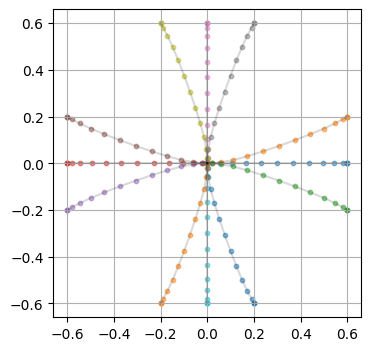

In [12]:
plotPrimitivesSet(primitives_symmetric_set_1)

___
#### Set #2

In [13]:
start_poses = [
    (0, 0, math.radians(30)),
    (0, 0, math.radians(-30)),
    (0, 0, math.radians(150)),
    (0, 0, math.radians(-150))
]

end_poses = [
    [ (0.6, 0.2, math.radians(0)),
      (0.6, 0.4, math.radians(30)),
      (0.4, 0.6, math.radians(60)) ],

    [ (0.6, -0.2, math.radians(0)),
      (0.6, -0.4, math.radians(-30)),
      (0.4, -0.6, math.radians(-60)) ],

    [ (-0.6, 0.2, math.radians(180)),
      (-0.6, 0.4, math.radians(150)),
      (-0.4, 0.6, math.radians(120)) ],

    [ (-0.6, -0.2, math.radians(-180)),
      (-0.6, -0.4, math.radians(-150)),
      (-0.4, -0.6, math.radians(-120)) ]
]

In [14]:
primitives_symmetric_set_2 = \
  buildPrimitivesSet(start_poses, end_poses)

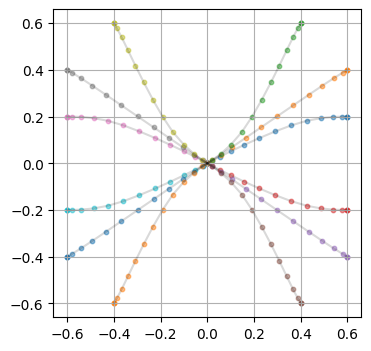

In [15]:
plotPrimitivesSet(primitives_symmetric_set_2)

___
#### Set #3

In [16]:
start_poses = [
    (0, 0, math.radians(60)),
    (0, 0, math.radians(-60)),
    (0, 0, math.radians(120)),
    (0, 0, math.radians(-120))
]

end_poses = [
    [ (0.2, 0.6, math.radians(90)),
      (0.4, 0.6, math.radians(60)),
      (0.6, 0.4, math.radians(30)) ],

    [ (0.6, -0.4, math.radians(-30)),
      (0.4, -0.6, math.radians(-60)),
      (0.2, -0.6, math.radians(-90)) ],

    [ (-0.2, 0.6, math.radians(90)),
      (-0.4, 0.6, math.radians(120)),
      (-0.6, 0.4, math.radians(150)) ],

    [ (-0.2, -0.6, math.radians(-90)),
      (-0.4, -0.6, math.radians(-120)),
      (-0.6, -0.4, math.radians(-150)) ]
]

In [17]:
primitives_symmetric_set_3 = \
  buildPrimitivesSet(start_poses, end_poses)

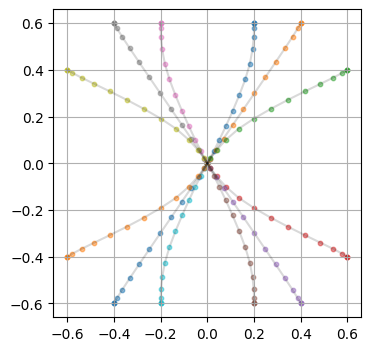

In [18]:
plotPrimitivesSet(primitives_symmetric_set_3)

___
#### Build

In [19]:
primitives_family = \
  primitives_symmetric_set_1 + \
  primitives_symmetric_set_2 + \
  primitives_symmetric_set_3

In [20]:
assert(len(primitives_family)) == 36

max_ = -math.inf
min_ = math.inf

for primitive in primitives_family:
  if primitive['a'].min() < min_:
    min_ = primitive['a'].min()

  if primitive['a'].max() > max_:
    max_ = primitive['a'].max()

assert(min_ >= min_yaw)
assert(max_ < max_yaw)

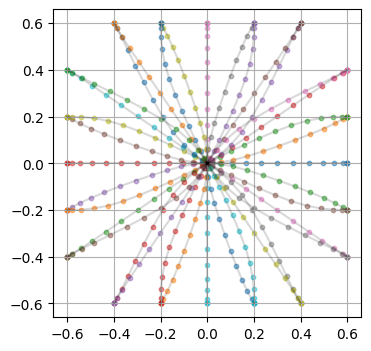

In [21]:
plotPrimitivesSet(primitives_family)

___
### Primitives Familiy *(Full & Complex)*

In [22]:
### --- TODO --- ###

___
### Export to JSON

In [23]:
def exportToJson(primitives, file_name='data'):
  data_json = dict()
  data_json['yaws'] = yaws

  data_json['primitives'] = []

  for primitive in primitives:
    primitive_arr = dict()
    primitive_arr['length'] = primitive['length']
    primitive_arr['x'] = list(primitive['x'])
    primitive_arr['y'] = list(primitive['y'])
    primitive_arr['a'] = list(primitive['a'])
    data_json['primitives'].append(primitive_arr)

  with open('{0}.json'.format(file_name), 'w') as f:
    json.dump(data_json, f)

  print('Exported to {0}.json'.format(file_name))

In [24]:
exportToJson(primitives_family, file_name='primitives')

Exported to primitives.json


___

In [25]:
### --- TODO --- ###
# Primitives can be grouped based on the yaw value in its initial pose.
#
# It turns out that each of our prepared yaw corresponds to a specific subset of primitives,
# this relation (through the indexes of the corresponding yaw and primitives) must be stored in .json,
# because it will increase speed of forming a valid subset of primitives for a vertex which is being created

___
___